# 分位数法

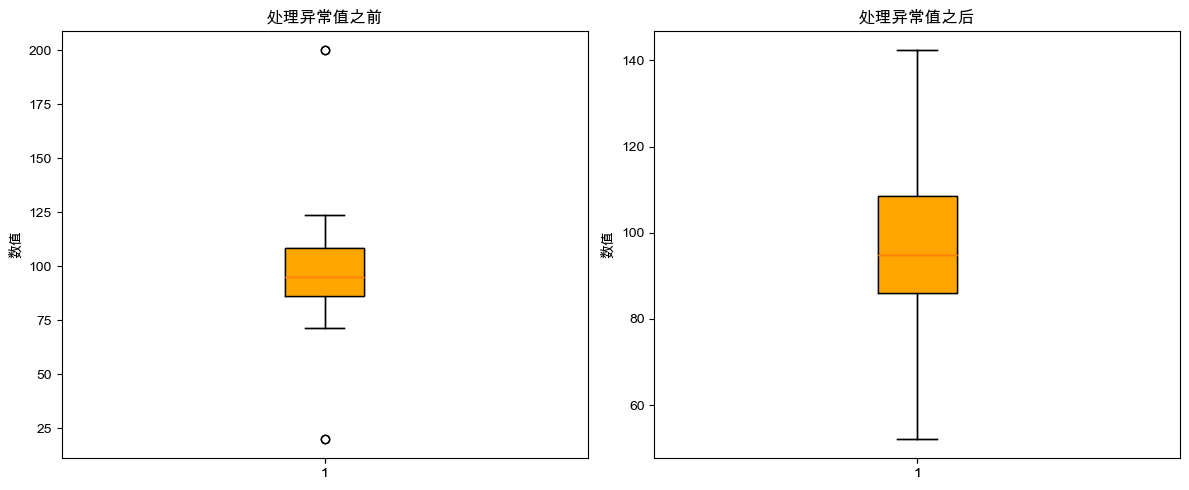

原始数据描述统计：
count     20.000000
mean      98.161684
std       32.722691
min       20.000000
25%       85.986612
50%       94.768217
75%      108.532633
max      200.000000
Name: values, dtype: float64

处理后数据描述统计：
count     20.000000
mean      96.887646
std       20.391138
min       52.167582
25%       85.986612
50%       94.768217
75%      108.532633
max      142.351663
Name: values_processed, dtype: float64


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 生成20个随机样本数据
np.random.seed(42)
data = np.random.normal(100, 15, 20)

# 添加一些异常值
data[0] = 200  # 添加一个较大的异常值
data[1] = 20   # 添加一个较小的异常值

# 创建DataFrame
df = pd.DataFrame(data, columns=['values'])

# 计算Q1、Q3和IQR
Q1 = df['values'].quantile(0.25)
Q3 = df['values'].quantile(0.75)
IQR = Q3 - Q1

# 设定异常值的上下界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 处理异常值（替换为边界值）
df['values_processed'] = df['values'].clip(lower=lower_bound, upper=upper_bound)
# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS系统使用Arial Unicode MS字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 可视化展示处理前后的数据
plt.figure(figsize=(12, 5))

# 处理前的箱线图
plt.subplot(121)
plt.boxplot(df['values'])
plt.title('处理异常值之前')
plt.ylabel('数值')
plt.boxplot(df['values'], patch_artist=True, boxprops=dict(facecolor='orange'))

# 处理后的箱线图
plt.subplot(122)
plt.boxplot(df['values_processed'])
plt.title('处理异常值之后')
plt.ylabel('数值')
plt.boxplot(df['values_processed'], patch_artist=True, boxprops=dict(facecolor='orange'))
plt.tight_layout()
plt.show()

# 打印处理前后的基本统计信息
print("原始数据描述统计：")
print(df['values'].describe())
print("\n处理后数据描述统计：")
print(df['values_processed'].describe())


# Z-score 标准化：减去平均值，除以标准差，得到标准化后的数值。大于3或小于-3的值被视为异常值。

# DBSCAN 密度聚类

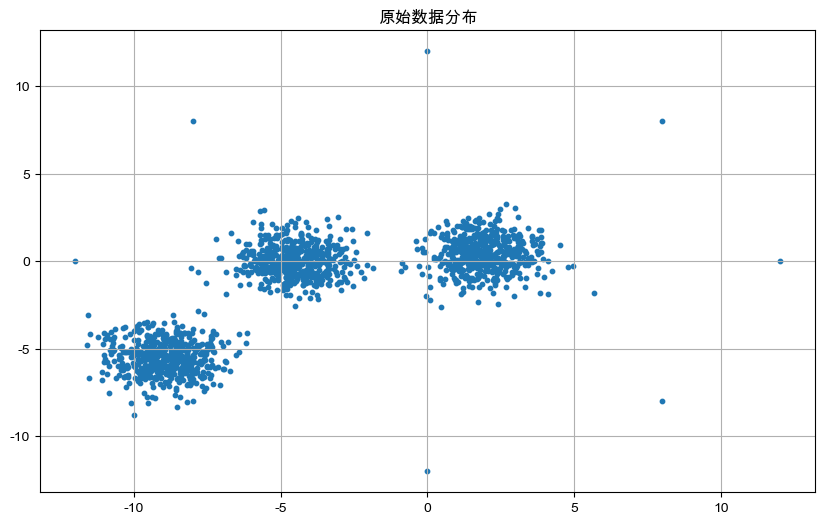

DBSCAN检测到的异常值数量: 58
异常值占比: 3.85%


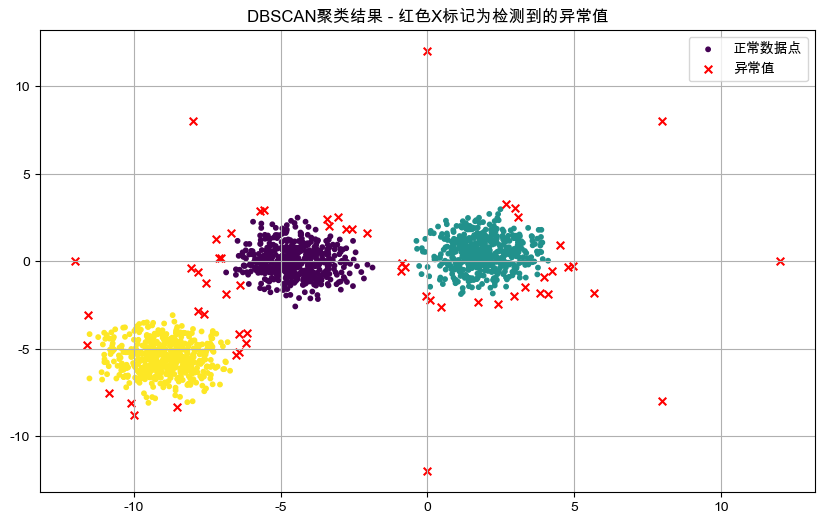


移除异常值后的数据形状: (1450, 2)
原始数据形状: (1508, 2)


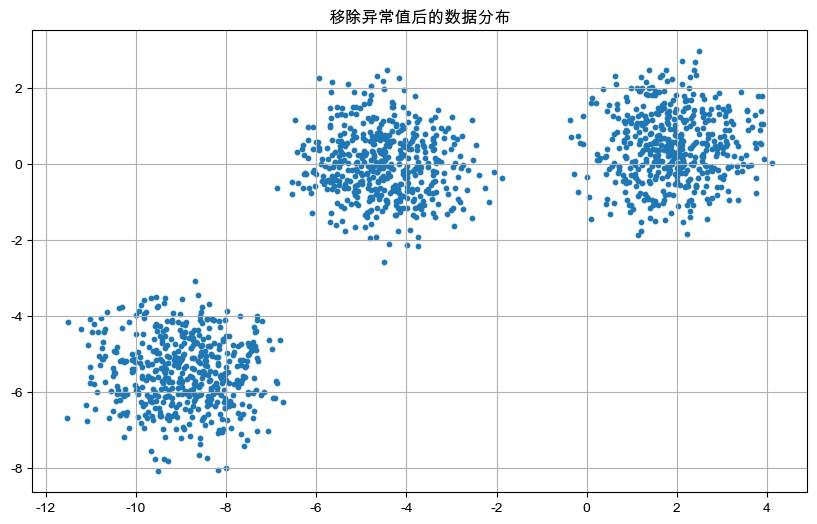

In [5]:
# 使用DBSCAN密度聚类进行异常值检测
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 生成随机数据
n_samples = 1500
random_state = 170
X, _ = make_blobs(n_samples=n_samples, random_state=random_state)

# 添加一些离群点
X = np.vstack([X, np.array([[8, 8], [-8, -8], [8, -8], [-8, 8], [12, 0], [-12, 0], [0, 12], [0, -12]])])

# 将数据转换为DataFrame以便于处理
df_dbscan = pd.DataFrame(X, columns=['x', 'y'])

# 绘制原始数据
plt.figure(figsize=(10, 6))
plt.scatter(df_dbscan['x'], df_dbscan['y'], s=10)
plt.title('原始数据分布')
plt.grid(True)
plt.show()

# 使用DBSCAN进行聚类
# eps: 邻域半径，min_samples: 成为核心点所需的最小样本数
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X)

# -1表示异常点（噪声点）
outliers_mask = clusters == -1
inliers_mask = clusters != -1

# 统计异常值数量
outliers_count = np.sum(outliers_mask)
print(f"DBSCAN检测到的异常值数量: {outliers_count}")
print(f"异常值占比: {outliers_count / len(X):.2%}")

# 绘制聚类结果，突出显示异常值
plt.figure(figsize=(10, 6))
plt.scatter(X[inliers_mask, 0], X[inliers_mask, 1], c=clusters[inliers_mask], cmap='viridis', s=10, label='正常数据点')
plt.scatter(X[outliers_mask, 0], X[outliers_mask, 1], c='red', s=30, marker='x', label='异常值') #scatter绘制散点图，marker='x'表示用X标记异常值
plt.title('DBSCAN聚类结果 - 红色X标记为检测到的异常值')
plt.legend()
plt.grid(True)
plt.show()

# 移除异常值后的数据
df_dbscan_cleaned = df_dbscan[~outliers_mask].copy()
print(f"\n移除异常值后的数据形状: {df_dbscan_cleaned.shape}")
print(f"原始数据形状: {df_dbscan.shape}")

# 绘制移除异常值后的数据
plt.figure(figsize=(10, 6))
plt.scatter(df_dbscan_cleaned['x'], df_dbscan_cleaned['y'], s=10)
plt.title('移除异常值后的数据分布')
plt.grid(True)
plt.show()


# 孤立森林

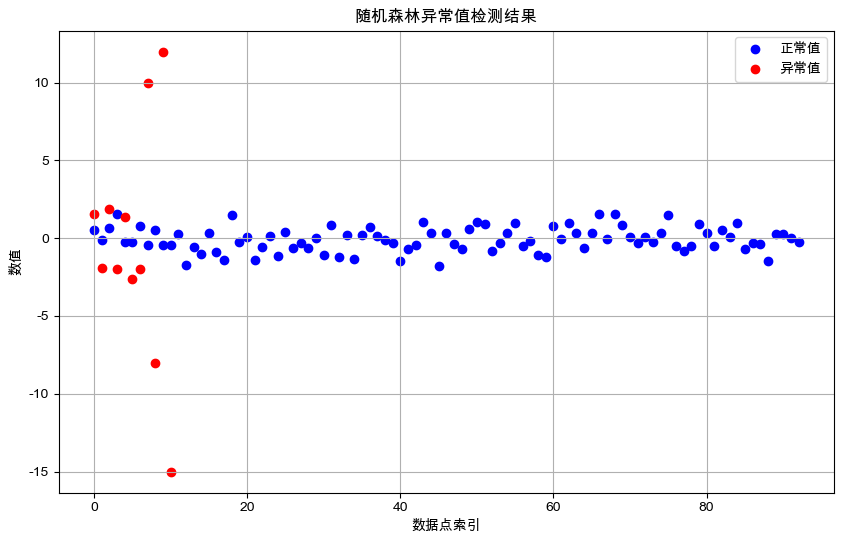


检测到的异常值:
            数据  是否为正常值
102  12.000000   False
100  10.000000   False
31    1.852278   False
6     1.579213   False
65    1.356240   False
13   -1.913280   False
37   -1.959670   False
79   -1.987569   False
74   -2.619745   False
101  -8.000000   False
103 -15.000000   False


In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# 创建一个包含异常值的示例数据
np.random.seed(42)
normal_data = np.random.normal(loc=0, scale=1, size=100)  # 生成正常数据
outliers = np.array([10, -8, 12, -15])  # 添加一些异常值
X = np.concatenate([normal_data, outliers])
X = X.reshape(-1, 1)

# 使用IsolationForest进行异常值检测
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
yhat = iso_forest.fit_predict(X)

# 将预测结果转换为布尔掩码（True表示正常值，False表示异常值）
mask = yhat != -1

# 创建一个DataFrame来展示结果
df = pd.DataFrame({
    '数据': X.flatten(),
    '是否为正常值': mask
})

# 绘制数据分布图
plt.figure(figsize=(10, 6))
#plt.scatter(range(len(X)), X[mask], c='blue', label='正常值')
plt.scatter(range(len(X[mask])), X[mask], c='blue', label='正常值')
#plt.scatter(range(len(X)), X[~mask], c='red', label='异常值')
plt.scatter(range(len(X[~mask])), X[~mask], c='red', label='异常值')
plt.title('随机森林异常值检测结果')
plt.xlabel('数据点索引')
plt.ylabel('数值')
plt.legend()
plt.grid(True)
plt.show()

# 打印检测到的异常值
print("\n检测到的异常值:")
print(df[~df['是否为正常值']].sort_values(by='数据', ascending=False))
